In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

import random
import numpy as np
import matplotlib.pyplot as plt

from math import ceil
from tqdm import tqdm

In [11]:
# Set manual seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#torch.use_deterministic_algorithms(True)

In [13]:
# Constants 
dataset_path = "../Dataset"
models_path  = "../models"
BATCH_SIZE = 512

if torch.cuda.is_available():
  _DEVICE = "cuda"
else:
  _DEVICE = "cpu"

In [14]:
# Helper functions
def count_parameters(NN):
    return sum([p.numel() for p in NN.parameters() if p.requires_grad==True])

def get_one_hot_encoder(labels):
    def ohe(target):
        oh_vec=torch.zeros(len(labels), dtype=torch.float)
        oh_vec[target] = 1.
        return oh_vec
    return ohe

In [15]:
# Dataset loader
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = datasets.ImageFolder(f'{dataset_path}/Train')
dataset = datasets.ImageFolder(f'{dataset_path}/Train', transform=transform, target_transform=get_one_hot_encoder(dataset.classes))

dataset_train, dataset_val = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), 
                                                                     ceil(len(dataset)*0.2)])

dataset_test  = datasets.ImageFolder(f'{dataset_path}/Test', transform=transform)

train_loader = data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = data.DataLoader(dataset_test,  batch_size=BATCH_SIZE, shuffle=True)
val_loader   = data.DataLoader(dataset_val,   batch_size=BATCH_SIZE, shuffle=True)

In [16]:
trainSteps = len(train_loader.dataset) // BATCH_SIZE
valSteps   = len(val_loader.dataset)  // BATCH_SIZE

In [20]:
resnet = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes in your dataset
num_classes = len(dataset_train.classes)  # Get the number of classes
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

AttributeError: 'Subset' object has no attribute 'classes'

In [9]:
# Load pretrained AlexNet
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

# Feezing parameters
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to C:\Users\david/.cache\torch\hub\v0.10.0.zip
c:\Users\david\Desktop\Code\DNN\DNNvenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\david\Desktop\Code\DNN\DNNvenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\david/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:40<00:00, 5.96MB/s] 


In [9]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=256, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=256, out_features=256, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=256, out_features=len(dataset.classes), bias=True)
)

In [10]:
print(f"trainable parameters: {count_parameters(model)}")

trainable parameters: 2428428


In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
model.load_state_dict(torch.load(f"{models_path}/v1.pt", weights_only=True))

<All keys matched successfully>

In [ ]:
N_EPOCH = 100

model.to(_DEVICE)
progress_bar = tqdm(range(0, N_EPOCH))
H = {"train_loss": [],	  "val_loss": []}
for epoch in progress_bar:
    totalTrainLoss = 0
    totalValLoss = 0
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(_DEVICE)
        outputs = model(inputs)
        targets = targets.to(torch.float32).to(_DEVICE)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        totalTrainLoss += loss

    with torch.no_grad():
      model.eval()
      for inputs, targets in val_loader:
        inputs = inputs.to(_DEVICE)
        outputs = model(inputs)
        targets = targets.to(_DEVICE)
        totalValLoss += loss_fn(outputs, targets)

    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss   = totalValLoss / valSteps
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    progress_bar.set_description(f"Train loss: {avgTrainLoss:.6f} | Val loss: {avgValLoss:.6f}")

In [14]:
torch.save(model.state_dict(), f"{models_path}/v1.pt")

In [15]:
predictions = list()

model.eval()
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to(_DEVICE)
        outputs = model(inputs)
        predictions.append(
            [inputs.cpu().detach(), outputs.cpu().detach()]
        )

100%|██████████| 16/16 [00:26<00:00,  1.67s/it]


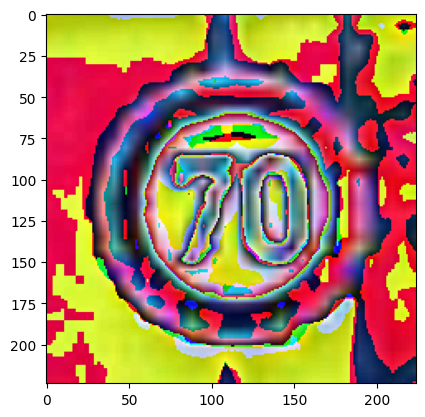

In [21]:
plt.imshow(F.to_pil_image(make_grid(predictions[3][0][0])))

In [22]:
predictions[3][1][0]

tensor([  5.4735, -14.3768,  -9.7193,  -9.6222,  -6.9533, -12.6774,   2.9675,
        -11.3538, -14.4483,  -8.2496, -11.9076,  -9.2337])

In [23]:
dataset.class_to_idx

{'1': 0,
 '12': 1,
 '13': 2,
 '14': 3,
 '15': 4,
 '17': 5,
 '2': 6,
 '23': 7,
 '25': 8,
 '26': 9,
 '28': 10,
 '33': 11}